In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from keras.models import Sequential,Model
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization,Activation,GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.densenet import DenseNet201,preprocess_input
from keras import optimizers
import matplotlib.pyplot as plt
import cv2

# Data Preprocessing

In [2]:
# Get path to all TRAIN & TEST files
#print("glob walk file")
train_paths = glob.glob('../input/AOI/train_images/*/*')
test_paths = glob.glob('../input/AOI/test_images/*/*')

print("No. Files in Train: {:,} pictures".format(len(train_paths)), "\n" +
      "No. Files in Test: {:,} pictures".format(len(test_paths)), "\n")

No. Files in Train: 2,528 pictures 
No. Files in Test: 10,142 pictures 



In [3]:
# label data
traindf = pd.read_csv('../input/AOI/train.csv',dtype=str)
testdf = pd.read_csv('../input/AOI/test.csv',dtype=str)
print("train.csv:\n",traindf.head())
print("\n\ntest.csv:\n",testdf.head())

train.csv:
                 ID Label
0  train_00000.png     0
1  train_00001.png     1
2  train_00002.png     1
3  train_00003.png     5
4  train_00004.png     5


test.csv:
                ID Label
0  test_00000.png   NaN
1  test_00001.png   NaN
2  test_00002.png   NaN
3  test_00003.png   NaN
4  test_00004.png   NaN


In [4]:
img_ex = cv2.imread('../input/AOI/train_images/train_images/train_00000.png')
print(img_ex.shape) #dim
#cv2.imshow('test', img_ex)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

(512, 512, 3)


In [5]:
# Hyperparamters 超參數則是則是由人為給定，例如神經網路的層數、損失函數、卷積核的大小、學習率等等
resize =128
batchsize = 32

# Data
train_gen = ImageDataGenerator(  #deal with picture(data argmentation)
    rescale=1./255.,
    #zca_whitening=False, # zca白化的作用是針對圖片進行PCA降維操作，減少圖片的冗餘信息，保留最重要的特徵
    #rotation_range=20,# Degree range for random rotations # 指定旋轉角度範圍,在 [0, 指定角度] 範圍內進行隨機角度旋轉
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2, # 線性變換推移 #讓所有點的x坐標(或者y坐標)保持不變，而對應的y坐標(或者x坐標)則按比例發生平移，且平移的大小和該點到x軸(或y軸)的垂直距離成正比
    #zoom_range=0.2, # 可以讓圖片在長或寬的方向進行放大
    horizontal_flip=True, # 水平翻轉
    vertical_flip=True, # 上下翻轉
    fill_mode='nearest', # 填充模式，當對圖片進行平移、放縮、錯切等操作時，圖片中會出現一些缺失的地方，設定這些缺失的地方該用什麼方式補全
    validation_split=0.2,  # set validation split
)
# training data
#train_data = train_gen.flow_from_directory(
train_data = train_gen.flow_from_dataframe(
    dataframe = traindf,
    directory = "../input/AOI/train_images/train_images",# 目標目錄
    x_col="ID",
    y_col="Label",
    target_size=(resize, resize), # picture change to resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode="categorical",
    #class_mode="binary",
    batch_size = batchsize,
    shuffle=True, # 是否隨機播放數據
    #save_format="png",
    follow_links=False,
    subset="training", # set as training data
    interpolation="nearest",
)
# validation data
#valid_data = train_gen.flow_from_directory(
valid_data = train_gen.flow_from_dataframe(
    dataframe = traindf,
    directory = "../input/AOI/train_images/train_images",# 目標目錄 # same directory as training data
    x_col="ID",
    y_col="Label",
    target_size=(resize, resize), # 所有影像調整為 resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode="categorical",
    batch_size = batchsize,
    shuffle=True, # 是否隨機播放數據
    #save_format="png",
    follow_links=False,
    subset="validation", # set as validation data
    interpolation="nearest",
)
# test data
test_gen = ImageDataGenerator(rescale=1./255.)
#test_data = test_gen.flow_from_directory(
test_data = test_gen.flow_from_dataframe(
    dataframe = testdf,
    directory = "../input/AOI/test_images/test_images",# 目標目錄
    x_col="ID",
    target_size=(resize, resize), # 所有影像調整為 resize x resize
    color_mode="rgb",
    #color_mode="grayscale",
    class_mode=None, # important!!!
    #class_mode="categorical",
    #class_mode="binary",
    batch_size = batchsize,
    shuffle=False, # 是否隨機播放數據
    #save_format="png",
    follow_links=False,
    subset=None,
    interpolation="nearest",
)

Found 2023 validated image filenames belonging to 6 classes.
Found 505 validated image filenames belonging to 6 classes.
Found 10142 validated image filenames.


# Reweight data class

In [19]:
from collections import Counter
counter = Counter(train_data.classes)
print(counter)
max_val = float(max(counter.values())) 
class_weights_dic = {class_id : (max_val/num_images) for class_id, num_images in counter.items()} 

sorted_items = sorted(class_weights_dic.items()) # Get key-value pairs and Sort dictionary by key
class_weights_dict = {class_id : weight for class_id, weight in sorted_items}
print(class_weights_dict)

Counter({0: 545, 5: 527, 1: 381, 3: 299, 4: 190, 2: 81})
{0: 1.0, 1: 1.4304461942257218, 2: 6.728395061728395, 3: 1.8227424749163879, 4: 2.8684210526315788, 5: 1.0341555977229602}


# Model

In [8]:
# Build model

base_model = DenseNet201(include_top=False)
x = base_model.output
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
# output layer
predictions=Dense(6,activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
              loss='categorical_crossentropy',
              #loss='binary_crossentropy',
              metrics=['accuracy'])

# Training

In [9]:
# callback setting
checkpoint = ModelCheckpoint('CNN_weights.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True,
                             save_weights_only=True, mode='auto')
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=1e-3, patience=15, mode='auto', baseline=None,
                          restore_best_weights=True)#min_delta=1e-3
reduceLR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, min_delta=1e-6,
                             min_lr=1e-8, mode='auto')

callbacks_list = [checkpoint, earlystop, reduceLR]

# train
train_history = model.fit_generator(
    train_data,
    epochs = 40,
    #steps_per_epoch = 80,
    validation_data = valid_data,
    callbacks = callbacks_list,
    # The class weights go here
    class_weight = class_weights_dict,
)
print("*+"*60)
print('Finish\n')

Epoch 1/40
64/64 [==============================] - 37s 303ms/step - loss: 0.9080 - accuracy: 0.6680 - val_loss: 1.2574 - val_accuracy: 0.4277
Epoch 2/40
64/64 [==============================] - 15s 241ms/step - loss: 0.1267 - accuracy: 0.9619 - val_loss: 0.8428 - val_accuracy: 0.6337
Epoch 3/40
64/64 [==============================] - 16s 255ms/step - loss: 0.0545 - accuracy: 0.9865 - val_loss: 0.6014 - val_accuracy: 0.7703
Epoch 4/40
64/64 [==============================] - 16s 244ms/step - loss: 0.0425 - accuracy: 0.9881 - val_loss: 0.4628 - val_accuracy: 0.8634
Epoch 5/40
64/64 [==============================] - 16s 245ms/step - loss: 0.0229 - accuracy: 0.9938 - val_loss: 0.5521 - val_accuracy: 0.7762
Epoch 6/40
64/64 [==============================] - 15s 240ms/step - loss: 0.0244 - accuracy: 0.9943 - val_loss: 0.2636 - val_accuracy: 0.9030
Epoch 7/40
64/64 [==============================] - 16s 249ms/step - loss: 0.0144 - accuracy: 0.9967 - val_loss: 0.2172 - val_accuracy: 0.9228

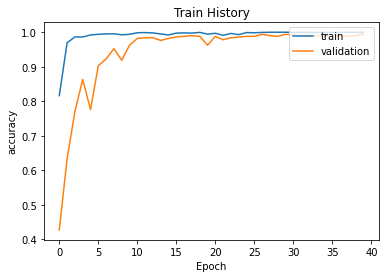

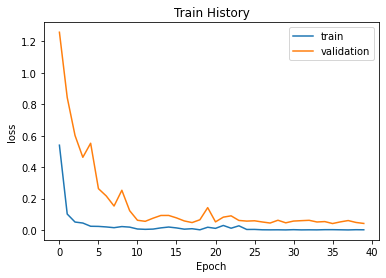

In [10]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(['train','validation'],loc='upper right')
    plt.show()

show_train_history(train_history, 'accuracy', 'val_accuracy')
show_train_history(train_history, 'loss', 'val_loss')

In [11]:
scores = model.evaluate(valid_data)
print('accuracy=',scores[1])

16/16 [==============================] - 3s 178ms/step - loss: 0.0573 - accuracy: 0.9921
accuracy= 0.9920791983604431


In [12]:
model.load_weights('CNN_weights.hdf5')

# Predict

In [13]:
# if you forget to reset the test_generator you will get outputs in a weird order
test_data.reset() # need to reset the test_generator before whenever you call the predict_generator

pred = model.predict_generator(test_data,
    verbose=1
)
#pred = model.predict_classes(test_data)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


317/317 [==============================] - 103s 318ms/step


In [14]:
# write predict result to file

#predictions=[]
predicted_class_indices = np.argmax(pred,axis=1) # 沿著行(axis=0)或列(axis=1)查詢最大值的索引號
labels = train_data.class_indices
labels = dict((v,k) for k,v in labels.items())
# 建立代碼標籤與真實標籤(種類名稱)的關係
predictions = [labels[i] for i in predicted_class_indices]

filenames = test_data.filenames
results=pd.DataFrame({"ID":filenames,
                      "Label":predictions})
results.to_csv("results.csv",index=False)
print(labels)
print(len(predictions))

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5'}
10142


In [15]:
model.save('Model.h5')

# Confusion Matrix (training and validation)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
# 計算「混淆矩陣」(Confusion Matrix)，顯示訓練集(train set)分類的正確及錯認總和數

scores = model.evaluate(train_data)
print('accuracy=',scores[1])

train_data.shuffle = False # 取消 shuffle 以對應正確的 label 和 predict class
train_data.index_array = None

#train_data.reset()
CM_train_Y_pred = model.predict_generator(train_data, verbose=1)
CM_train_y_pred = np.argmax(CM_train_Y_pred, axis=1)

print('\nConfusion Matrix (sklearn version)')
print(confusion_matrix(train_data.classes, CM_train_y_pred)) # labels = [0, 1, 2, 3, 4, 5]

print('\nConfusion Matrix (pandas version)')
data_train_y_label = np.array(train_data.classes)
print( pd.crosstab(data_train_y_label, CM_train_y_pred, rownames=['Label'], colnames=['Predict']) )

print('\nClassification Report')
target_names = ['0 normal', '1 void', '2 horizontal defect', '3 vertical defect', '4 edge defect', '5 particle']
print(classification_report(train_data.classes, CM_train_y_pred, target_names=target_names))

64/64 [==============================] - 11s 178ms/step - loss: 0.0012 - accuracy: 0.9995
accuracy= 0.9995056986808777


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


64/64 [==============================] - 14s 170ms/step

Confusion Matrix (sklearn version)
[[545   0   0   0   0   0]
 [  0 381   0   0   0   0]
 [  0   0  81   0   0   0]
 [  0   0   0 299   0   0]
 [  0   0   0   0 190   0]
 [  0   0   0   0   0 527]]

Confusion Matrix (pandas version)
Predict    0    1   2    3    4    5
Label                               
0        545    0   0    0    0    0
1          0  381   0    0    0    0
2          0    0  81    0    0    0
3          0    0   0  299    0    0
4          0    0   0    0  190    0
5          0    0   0    0    0  527

Classification Report
                     precision    recall  f1-score   support

           0 normal       1.00      1.00      1.00       545
             1 void       1.00      1.00      1.00       381
2 horizontal defect       1.00      1.00      1.00        81
  3 vertical defect       1.00      1.00      1.00       299
      4 edge defect       1.00      1.00      1.00       190
         5 particle     

In [17]:
# 計算「混淆矩陣」(Confusion Matrix)，顯示驗證集(validation set)分類的正確及錯認總和數

scores = model.evaluate(valid_data)
print('accuracy=',scores[1])

# Confution Matrix and Classification Report

valid_data.shuffle = False # 取消 shuffle 以對應正確的 label 和 predict class
valid_data.index_array = None

#valid_data.reset()
CM_valid_Y_pred = model.predict_generator(valid_data, verbose=1)
CM_valid_y_pred = np.argmax(CM_valid_Y_pred, axis=1)

print('\nConfusion Matrix (sklearn version)')
print(confusion_matrix(valid_data.classes, CM_valid_y_pred)) # labels = [0, 1, 2, 3, 4, 5]

print('\nConfusion Matrix (pandas version)')
data_valid_y_label = np.array(valid_data.classes)
print( pd.crosstab(data_valid_y_label, CM_valid_y_pred, rownames=['Label'], colnames=['Predict']) )

print('\nClassification Report')
target_names = ['0 normal', '1 void', '2 horizontal defect', '3 vertical defect', '4 edge defect', '5 particle']
print(classification_report(valid_data.classes, CM_valid_y_pred, target_names=target_names))

16/16 [==============================] - 3s 197ms/step - loss: 0.0522 - accuracy: 0.9881
accuracy= 0.9881188273429871


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


16/16 [==============================] - 3s 166ms/step

Confusion Matrix (sklearn version)
[[129   0   0   0   0   0]
 [  1 110   0   0   0   0]
 [  0   0  19   0   0   0]
 [  0   2   0  77   0   0]
 [  0   0   0   1  49   0]
 [  0   0   0   0   0 117]]

Confusion Matrix (pandas version)
Predict    0    1   2   3   4    5
Label                             
0        129    0   0   0   0    0
1          1  110   0   0   0    0
2          0    0  19   0   0    0
3          0    2   0  77   0    0
4          0    0   0   1  49    0
5          0    0   0   0   0  117

Classification Report
                     precision    recall  f1-score   support

           0 normal       0.99      1.00      1.00       129
             1 void       0.98      0.99      0.99       111
2 horizontal defect       1.00      1.00      1.00        19
  3 vertical defect       0.99      0.97      0.98        79
      4 edge defect       1.00      0.98      0.99        50
         5 particle       1.00      1.00 